# 1. Introdução e Apresentação do Projeto

&ensp; O notebook abaixo apresenta a solução criada por Lucas Nepomuceno do Ateliê 13 do Inteli para o desafio "Qual o Próximo hit do Spotify". Nele está exposto a exploração dos dados, os processos de limpeza, a codificação, a formulação de hipóteses, a seleção de features, a construção e avaliação do modelo, o finetuning de hiperparâmetros e a apresentação de resultados, nesta ordem. Vale salientar que esta é uma solução de aprendizado supervisionado e como tal, deve prever, com base nas features selecionadas do modelo, se uma música é ou não popular. Iniciamos esse processo com a importação das bibliotecas.

# 2. Configurações Iniciais

## 2.1. Importação das Bibliotecas

In [3213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


&ensp; Em seguida, deve-se importar a base de dados.

## 2.2. Importação da base de dados

In [3214]:
df = pd.read_csv('train.csv')

## 2.3. Processo 1: Exploração Inicial dos Dados

&ensp; Antes de iniciar qualquer trabalho no banco de dados é essencial compreender como esse *DataFrame* está estruturado. Compreende-se, primeiro, quais são as colunas, de que tipo são e em escala estão. Procura-se, então, por padrões, tendências e correlações nos dados, preparando-o também o processo de limpeza e seleção de features.

### 2.3.1. Compreendendo o *DataFrame*

&ensp; A fim de entender o conteúdo de cada coluna de maneira superficial, usa-se o método ``head()``

In [3215]:
pd.set_option('display.max_columns', 100)
df.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,16326,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,109799,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


&ensp; Para entender a estrutura dos dados, como o tipo e a quantidade de valores não-nulos, utilizamos o metódo ``info()``

In [3216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79800 non-null  int64  
 1   track_id           79800 non-null  object 
 2   artists            79800 non-null  object 
 3   album_name         79800 non-null  object 
 4   track_name         79800 non-null  object 
 5   duration_ms        79800 non-null  int64  
 6   explicit           79800 non-null  bool   
 7   danceability       79800 non-null  float64
 8   energy             79800 non-null  float64
 9   key                79800 non-null  int64  
 10  loudness           79800 non-null  float64
 11  mode               79800 non-null  int64  
 12  speechiness        79800 non-null  float64
 13  acousticness       79800 non-null  float64
 14  instrumentalness   79800 non-null  float64
 15  liveness           79800 non-null  float64
 16  valence            798

&ensp; Esta tabela nos permite verificar que todas as colunas em nosso DataFrame estão completamente preenchidas. Portanto, o processo de tratar valores nulos na limpeza, por exemplo, pode ser descartado. Além disso, é possível observar que há uma coluna do tipo ``bool`` (coluna ``explicit``) que provavelmente será transformada durante o processo de limpeza, pois outras colunas booleanas utilizam o tipo ``int`` em nosso *DataFrame*. Atenta-se, também, ao fato de que o DataFrame é composto de colunas númericas e categóricas, de modo que esta última deverá ser transformada em colunas númericas para a sua utilização nos modelos de aprendizado de máquinas. Por último, evidencia-se que no caso de nosso *DataFrame*, há dois ids, além do index de cada linha.

&ensp; O próximo passo na compreensão da tabela é entender a variedade de instâncias únicas em cada coluna. Para tanto, utiliza-se ``nunique()``.

In [3217]:
df.nunique()

track_unique_id      79800
track_id             66720
artists              25775
album_name           37315
track_name           55767
duration_ms          40712
explicit                 2
danceability          1120
energy                1932
key                     12
loudness             17562
mode                     2
speechiness           1454
acousticness          4856
instrumentalness      5252
liveness              1706
valence               1737
tempo                37292
time_signature           5
track_genre            114
popularity_target        2
dtype: int64

&ensp; Esta verificação inicial já evidencia que apenas ``track_unique_id`` pode ser tomado como o índice desse DataFrame. Enquanto isso, ``track_id`` permanece sendo uma incógnita. Portanto, faz-se:

In [3218]:
df = df.set_index('track_unique_id')

&ensp; Além disso, pode-se averiguar a distribuição de popularidade antes do processo de limpeza a fim de se certificar do balanceamento das classes popular e não popular em nosso banco de dados.

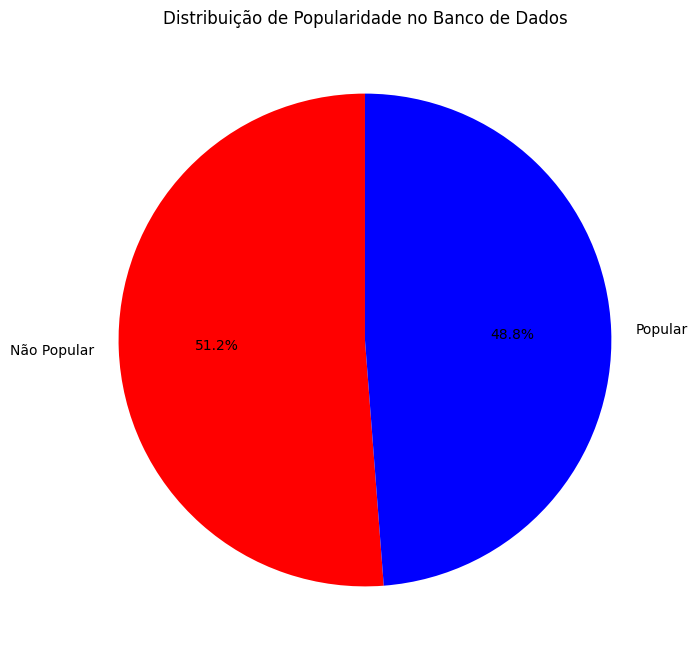

In [3219]:
# Contando os valores
sizes = df['popularity_target'].value_counts()
labels = df['popularity_target'].unique()

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=['Não Popular', 'Popular'], autopct='%1.1f%%', startangle=90, colors=['r', 'b'])

# Exibindo o gráfico
plt.title('Distribuição de Popularidade no Banco de Dados')
plt.show()

&ensp; Vê-se, portanto que pré-limpeza, as classes estão balanceadas.

### 2.3.2. Tendências, Padrões e Correlações

&ensp; Para familiarizar-se com os dados estudados, é preciso compreendê-los profundamente e uma das maneiras de se fazer isso é procurar por padrões, tendências e correlações no banco de dados.

&ensp; Observemos, por exemplo, a média das faixas em termos de ``duration_ms``, ``danceability``, ``energy``, ``loudness``, ``speechiness``, ``acousticness``, ``instrumentalness``, ``liveness``, e ``valence``

In [3220]:
df[['duration_ms','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].mean()

duration_ms         227902.192506
danceability             0.567318
energy                   0.641529
loudness                -8.263741
speechiness              0.084750
acousticness             0.314979
instrumentalness         0.157319
liveness                 0.213313
valence                  0.474267
dtype: float64

&ensp; Alguns aspectos ficam evidentes ao se analisar as médias destas colunas. O primeiro é a média negativa que aparece em ``loudness``. Dado que esta coluna deve representar o volume das músicas em décibeis, infere-se a existência de, pelo menos, um valor incorretamente inserido nesta coluna. Isso, pois ``loudness`` deveria conter apenas valores positivos. Observa-se também a baixa presença de palavras faladas nas faixas de nosso banco de dados representada pelo baixíssimo valor médio de ``speechness`` (< 0.1), o que é incomum.

&ensp; Outras questões interessantes podem ser abordadas pela média. Por exemplo, o valor médio de positividade é menor que 0.5, o que indicam músicas mais tristes ou apáticas. Não obstante, a faixa média em nosso banco de daods é dançante e enérgica, o que constitui uma composição complexa: dançante e enérgica, porém baixo-astral. 

&ensp; Pode-se também verificar outras medidas, além da média, em nosso banco de dados, utilizando-se o ``describe()``

In [3221]:
df[['duration_ms','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].describe()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
count,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,2.279022e+05,0.567318,0.641529,-8.263741,0.084750,0.314979,0.157319,0.213313,0.474267
std,1.050599e+05,0.173110,0.251441,5.035504,0.105657,0.332512,0.310792,0.190075,0.259010
min,1.338600e+04,0.000000,0.000019,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.744360e+05,0.456000,0.472000,-10.006000,0.035900,0.017000,0.000000,0.097900,0.261000
50%,2.128130e+05,0.581000,0.685000,-7.012000,0.049000,0.169000,0.000041,0.132000,0.464000
75%,2.614260e+05,0.695000,0.854000,-5.000000,0.084500,0.598000,0.050500,0.273000,0.684000
max,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000


&ensp; Apesar da grande quantidade de informações na tabela acima, pode-se verificar algumas características das variáveis que estamos discutindo. O primeiro é que as músicas possuem duração média de aproximadamente 4 minutos. Porém, um dos aspectos mais claros é a constituição estranha da coluna ``loudness``, na qual média e quartis são negativos. Para melhor visualização deste comportamento, gera-se o seguinte *box plot*.

Text(0.5, 1.0, 'Box Plot dos Valores de Loudness Sem Outliers')

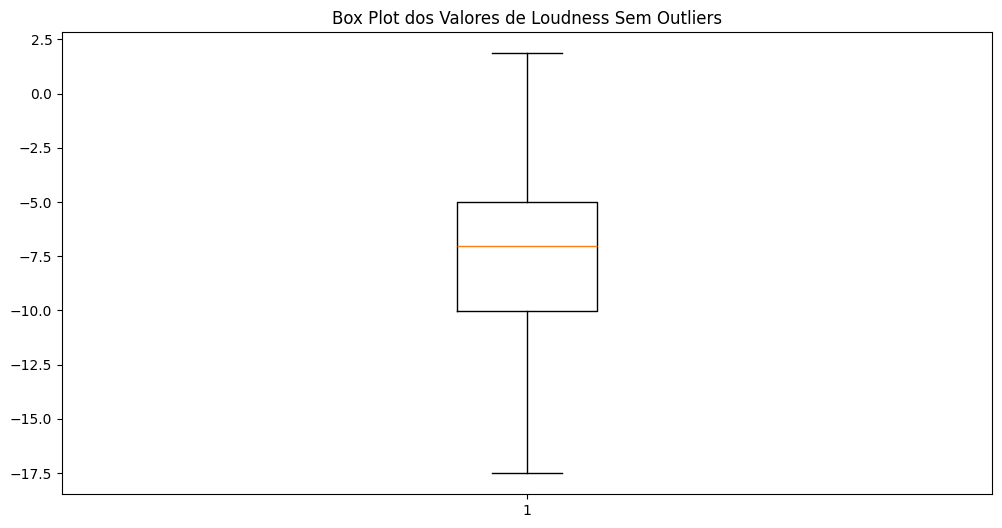

In [3222]:
plt.figure(figsize=(12,6))

plt.boxplot(df['loudness'], showfliers=False)
plt.title('Box Plot dos Valores de Loudness Sem Outliers')

OBS: Para tratarmos da estrutura da coluna, resolveu-se por retirar os outliers da visualização

&ensp; Como é possível observar no *box plot* acima, a coluna *loudness* contém dados majoritariamente negativos. Isto revela um aspecto a ser tratado com ponderação no processo de limpeza, pois esta coluna está, portanto, majoritariamente constituída de dados incorretos.

In [3223]:
#Repetição proposital para a continuidade da análise
df[['duration_ms','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].describe()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
count,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,2.279022e+05,0.567318,0.641529,-8.263741,0.084750,0.314979,0.157319,0.213313,0.474267
std,1.050599e+05,0.173110,0.251441,5.035504,0.105657,0.332512,0.310792,0.190075,0.259010
min,1.338600e+04,0.000000,0.000019,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.744360e+05,0.456000,0.472000,-10.006000,0.035900,0.017000,0.000000,0.097900,0.261000
50%,2.128130e+05,0.581000,0.685000,-7.012000,0.049000,0.169000,0.000041,0.132000,0.464000
75%,2.614260e+05,0.695000,0.854000,-5.000000,0.084500,0.598000,0.050500,0.273000,0.684000
max,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000


&ensp; A partir da tabela acima, pode-se observar também a alta dispersão dos dados nas colunas ``acousticness`` e ``instrumentalness``, de modo que a média *per se* não os representa de maneira tão eficaz. Logo, espera-se que nosso banco de dados contenha dados bastante variados no que tange à essas variáveis. Por sua vez, isso pode ser verificado a partir dos dois box plots abaixo.

(0.0, 1.0)

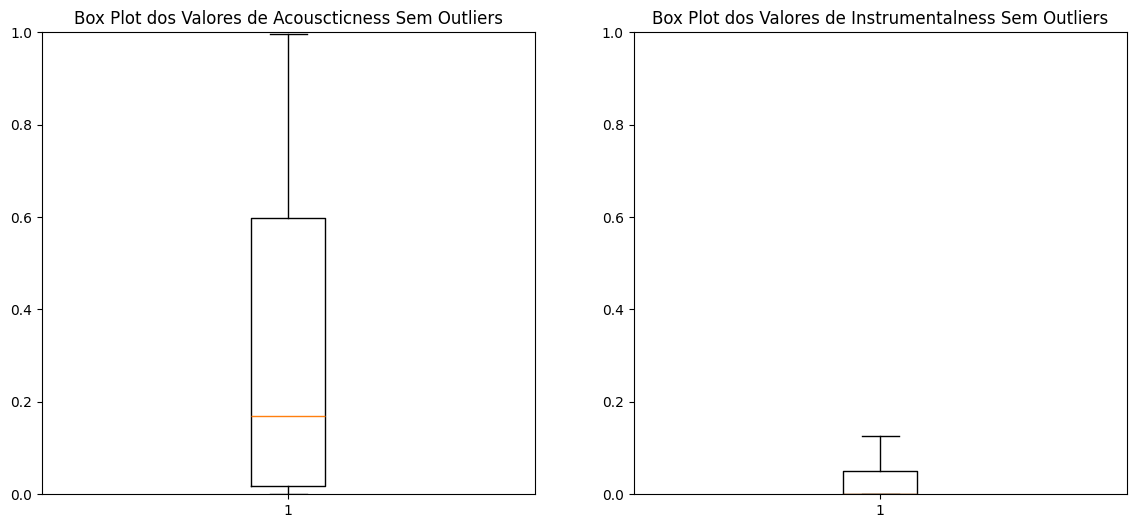

In [3224]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].boxplot(df['acousticness'], showfliers=False)
axs[0].set_title('Box Plot dos Valores de Acouscticness Sem Outliers')
axs[0].set_ylim(0, 1)  # Definindo a escala de 0 a 1

axs[1].boxplot(df['instrumentalness'], showfliers=False)
axs[1].set_title('Box Plot dos Valores de Instrumentalness Sem Outliers')
axs[1].set_ylim(0, 1)

OBS: Para tratarmos da estrutura das colunas, optou-se por retirar os outliers da visualização

&ensp; Com a visualização, constata-se também uma constrastante diferença entre os dois dados não obstante a similaridade em desvio padrão. Enquanto, ``acousctiness`` contém uma grande variedade de valores, ``instrumentalness`` contém uma variedade baixíssima com um intervalo interquartil que vai de 0 à 0.050500. Isso revela que a maioria das faixas do banco de dados estão previstas para não conter vocais, mas serem acústicas. Deste modo, um risco de nosso algoritmo ao levar ``instrumentalness`` em consideração é produzir um ``overfit`` para faixas sem vocais, sem capacidade de generalização em faixas que os contém.

&ensp; Outro padrão relevante em nosso banco de dados é a averiguação das modas nas variáveis categóricas. Para tanto, utiliza-se ``mode()``.

In [3225]:
artist_mode = df['artists'].mode()[0]
album_mode = df['album_name'].mode()[0]
key_mode = df['key'].mode()[0]
genre_mode = df['track_genre'].mode()[0]
signature_mode = df['time_signature'].mode()[0]

print(f'O(s) artista(s) ou banda mais frequente em nosso banco de dados é: {artist_mode} com {df.loc[df['artists'] == artist_mode].shape[0]} ocorrências')
print(f'O albúm mais frequente em nosso banco de dados é: {album_mode} com {df.loc[df['album_name'] == album_mode].shape[0]} ocorrências')
print(f'A tonalidade mais frequente em nosso banco de dados é: {key_mode} com {df.loc[df['key'] == key_mode].shape[0]} ocorrências')
print(f'A chave de compasso mais frequente em nosso banco de dados é: {signature_mode} com {df.loc[df['time_signature'] == signature_mode].shape[0]} ocorrências')
print(f'O gênero de música mais frequente em nosso banco de dados é: {genre_mode} com {df.loc[df['track_genre'] == genre_mode].shape[0]} ocorrências')
if df['explicit'].mode()[0]:
    print('A maioria das músicas possui conteúdo explícito')  
else:
    print('A maioria das músicas não contém conteúdo explícito')

O(s) artista(s) ou banda mais frequente em nosso banco de dados é: The Beatles com 194 ocorrências
O albúm mais frequente em nosso banco de dados é: Alternative Christmas 2022 com 131 ocorrências
A tonalidade mais frequente em nosso banco de dados é: 7 com 9261 ocorrências
A chave de compasso mais frequente em nosso banco de dados é: 4 com 71202 ocorrências
O gênero de música mais frequente em nosso banco de dados é: progressive-house com 738 ocorrências
A maioria das músicas não contém conteúdo explícito


&ensp; A análise da moda explicita algumas características esperadas e não esperadas de nosso banco de dados. Por exemplo, The Beatles ser a banda mais frequente não é incomum e esperava-se que a maioria das músicas não contivesse conteúdo explícito; entretanto, é incomum observar que o gênero mais comum no banco não é algo atual como o *pop* ou o *k-pop*, mas sim, *progressive-house*, um subgênero do House-Music da década de 1990 (WIKIPEDIA, 2003).

&ensp; Com a finalidade de aprofundar nossas análises, poderíamos visualizar a quantidade de ocorrências para cada valor único das colunas categóricas. Entretanto, sabe-se que a grande quantidade de valores únicos em artista e álbum afetaria a qualidade das análises. Por essa razão, produz-se isto somente para colunas com menos valores únicos como ``time_signature`` e ``key``.

Text(0.5, 1.0, 'Quantidade de Ocorrências por Tonalidade')

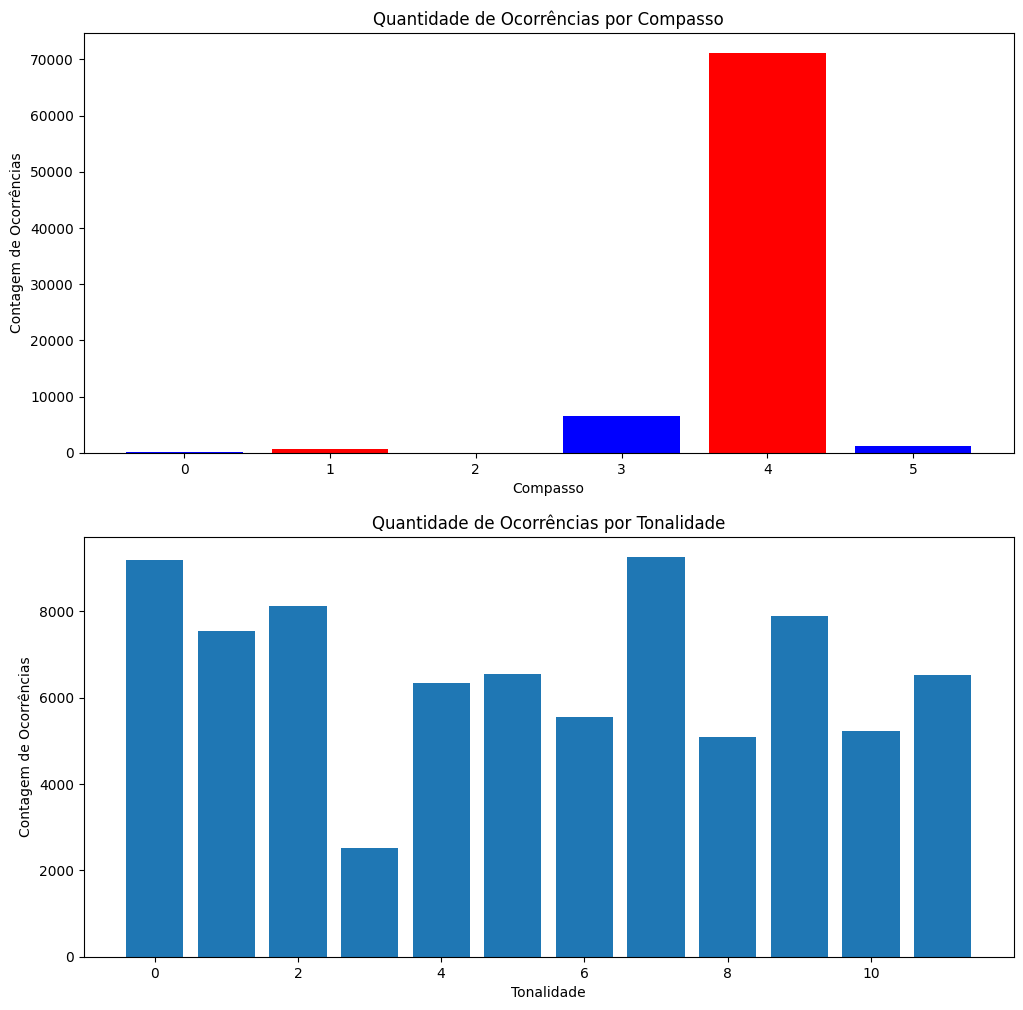

In [3226]:
fig, axs = plt.subplots(2,1,figsize=(12,12))

time_signature_valores = df['time_signature'].value_counts()
key_valores = df['key'].value_counts()


axs[0].bar(time_signature_valores.index, time_signature_valores.values, color=['red', 'blue', 'blue'])

axs[0].set_xlabel('Compasso')
axs[0].set_ylabel('Contagem de Ocorrências')
axs[0].set_title('Quantidade de Ocorrências por Compasso')

axs[1].bar(key_valores.index, key_valores.values)
axs[1].set_xlabel('Tonalidade')
axs[1].set_ylabel('Contagem de Ocorrências')
axs[1].set_title('Quantidade de Ocorrências por Tonalidade')

&ensp; A partir da leitura do primeiro gráfico acima, pode-se observar que nosso banco de dados contém muita mais faixas pertencentes ao compasso 4/4 do que todos os outros somados. Desta forma, questiona-se a relevância dessa coluna para o nosso banco, pois trata-se de uma coluna de baixíssima variância. Enquanto isso, a tonalidade das músicas varia bastante de acordo com sua classe de altura. Os dados estão bem distribuídos neste caso, mas são praticamente iguais naqueles.

#### 2.3.1.1 Correlação entre variáveis

&ensp; Outra característica relevante a se pontuar acerca das variáveis é sua correlação entre si. Para isso, pode-se utilizar o método ``corr()`` nas colunas numéricas.

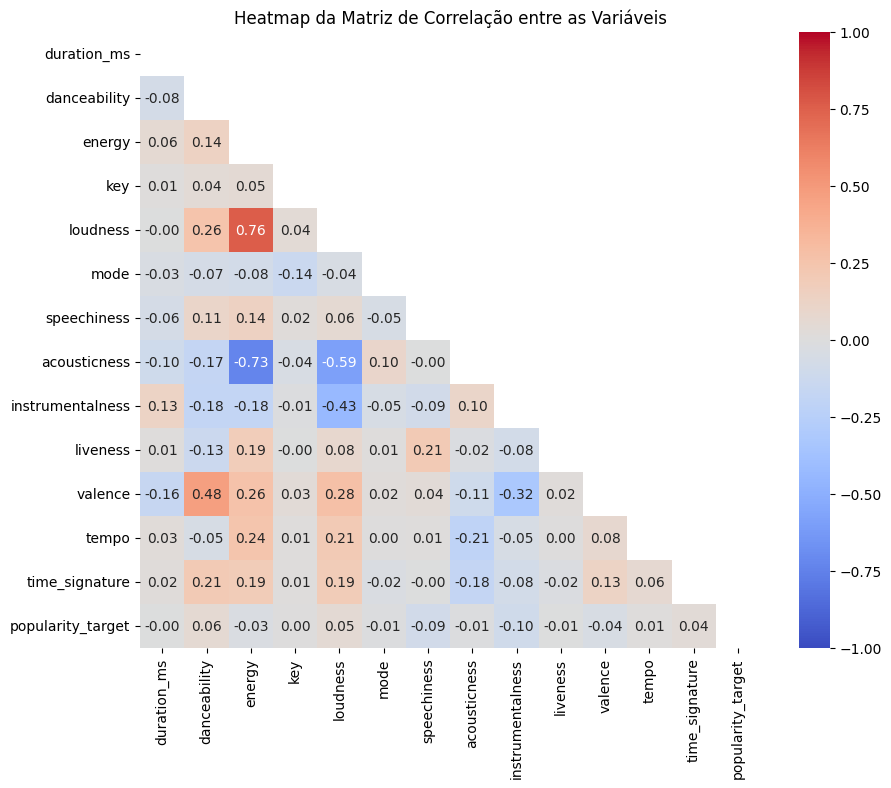

In [3227]:
corr = df.select_dtypes(include='number').corr()
# Criando uma máscara para ocultar a parte superior da matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Criando o heatmap
plt.figure(figsize=(10, 8))  # Ajustando o tamanho do gráfico
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

# Exibindo o gráfico
plt.title('Heatmap da Matriz de Correlação entre as Variáveis')
plt.show()

&ensp; O mapa de calor acima demonstra a correlação entre as variáveis, sendo que esta varia de -1 (correlação negativa forte) à 1 (correção positiva forte). Atentando-se à ele, pode-se verificar características esperadas e inesperadas.

&ensp; Entre as esperadas está a relação inversa entre a energia da música e a acústica. Isso, pois, músicas acústicas em oposição à músicas eletrônicas tendem a ser mais calmas. Inclusive, artistas costumam criar versões acústicas de suas músicas que são menos intensas. Além desta está a correlação razoável entre a positividade de uma música com sua "dançabilidade". Estes dois aspectos eram esperados

&ensp; No entanto, é uma surpresa que nenhuma das colunas númericas estabeleçam sequer uma correlação razoável com a popularidade. Isso indica que a popularidade de uma música pode se dar por aspectos completamente distintos, não se restringindo a apenas uma característica como a positividade ou a "dançabilidade". No mais, a correlação forte que era esperada entre ``energy`` e ``loudness`` foi uma surpresa. Não porque o não se esperava isso na realidade, já que espera-se que músicas mais altas sejam mais intensas. Mas sim, pois havíamos concluído previamente que os dados em ``loudness`` estavam incorretos. A partir dessa observação, porém, questiona-se se esse erro não se deu em um padrão (como adicionar um sinal negativo em todas as linhas).


### 2.3.3. Conclusão

&ensp; O processo de exploração inicial dos dados revelou algumas características relevantes do nosso banco de dados, dentre os quais alguns serão tratados posteriormente neste notebook. Por exemplo, revelou-se a coluna ``track_id`` que não agrega valor ao nosso banco de dados. Ademias, viu-se a coluna ``key``, cuja baixa variância parece apontar para a sua deleção do *DataFrame*. Outros aspectos como a duração média das músicas, a banda e o gênero musical mais frequentes e a correlação entre variáveis também foram abordados. A soma desses fatores contribuíram para o levantamento das seguintes hipóteses:

1. Apesar de nenhuma variável númerica da música, por si, indicar a popularidade da música, sugere-se que uma combinação de variáveis o faça. Portanto, hipotetiza-se que um conjunto de variáveis feliz, como alta ``valence``, alta ``energy`` e alta ``danceability`` contenha mais músicas populares do que não populares;

2. Espera-se que o autor(a) da música influencie mais na popularidade da música do que suas características musicais. Portanto, hipotetiza-se que a maioria das músicas do The Beatles sejam populares;

3. Dado que das variáveis númericas expostas, nenhuma é correlacionada com a popularidade, talvez a familiaridade o seja. Portanto, hipotetiza-se que os artistas mais recorrentes no banco de dados tenham mais músicas populares do que o contrário.

&ensp; Infelizmente, essas hipóteses só poderão ser averiguadas após o processo de limpeza de dados. Desta forma, concluí-se aqui a seção de Exploração Inicial dos Dados.

# 3. Processo 2: Limpeza de Dados

Abaixo está exposto o entendimento inicial dos dados e a subsequente limpeza.

## 3.1. Tratamento de valores nulos

&ensp; O primeiro passo do processo de limpeza é compreender o que fazer com os valores nulos. Sendo assim, é preciso verificar primeiro se há valores nulos no banco de dados. Para tanto, utiliza-se ``.info()``

In [3228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79800 entries, 41996 to 15795
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           79800 non-null  object 
 1   artists            79800 non-null  object 
 2   album_name         79800 non-null  object 
 3   track_name         79800 non-null  object 
 4   duration_ms        79800 non-null  int64  
 5   explicit           79800 non-null  bool   
 6   danceability       79800 non-null  float64
 7   energy             79800 non-null  float64
 8   key                79800 non-null  int64  
 9   loudness           79800 non-null  float64
 10  mode               79800 non-null  int64  
 11  speechiness        79800 non-null  float64
 12  acousticness       79800 non-null  float64
 13  instrumentalness   79800 non-null  float64
 14  liveness           79800 non-null  float64
 15  valence            79800 non-null  float64
 16  tempo              7980

In [3229]:
df.shape[0]

79800

&ensp; Como havíamos verificado no processo de exploração dos dados, dado que o número de linhas é igual ao número de linhas não nulas para todas as colunas, não há valores nulos e esse processo da limpeza pode ser pulado.

## 3.2. Valores Duplicados

&ensp; O segundo passo do processo de limpeza é a retirada de linhas duplicadas

&ensp; Pode-se verificar a quantidade de linhas duplicadas utilizando o método  ``duplicated()`` associado ao método ``value_counts()``

In [3230]:
df.duplicated().value_counts()

False    79569
True       231
Name: count, dtype: int64

&ensp; Este método revelou 231 duplicatas. Estas são ocorrências perfeitamente iguais no banco de dados que portanto devem ser apagadas. Abaixo, explicita-se esse processo.

In [3231]:
df = df.drop_duplicates(keep='first')

&ensp; Verifica-se abaixo se o método realmente funcionou.

In [3232]:
df.duplicated().value_counts()

False    79569
Name: count, dtype: int64

### 3.2.1. Duplicatas Parciais

&ensp; A coluna ``track_id`` é hasheada e sendo assim, funciona como uma senha atrapalhando a generalização do modelo, pois contém muitos valores únicos.

In [3233]:
df['track_id'].nunique()

66720

&ensp; Portanto, abaixo essa coluna é retirada para verificação de duplicatas em outras colunas.

In [3234]:
df.drop(columns=['track_id'], inplace=True)

In [3235]:
df.duplicated().value_counts()

False    79432
True       137
Name: count, dtype: int64

&ensp; Ao retirar a coluna ``track_id``, encontra-se outras 137 duplicatas. Estas também devem ser apagadas.

In [3236]:
df = df.drop_duplicates(keep='first')

&ensp; Verifica-se abaixo se o método realmente funcionou.

In [3237]:
df.duplicated().value_counts()

False    79432
Name: count, dtype: int64

### 3.2.1.1. Duplicatas Musicais

&ensp; Mais do que duplicatas perfeitas, no contexto deste projeto, podem-se considerar duplicatas músicas que são completamente iguais, mas que apenas o álbum ou o gênero se modifica. Abaixo, procura-se dados assim e remove-se as duplicatas.

In [3238]:
df_no_genre = df.drop(columns=['track_genre']).copy()

In [3239]:
duplicates = df_no_genre.duplicated(keep='first')

In [3240]:
duplicates.value_counts()

False    66616
True     12816
Name: count, dtype: int64

In [3241]:
df = df[~duplicates]

&ensp; O mesmo é feito para o caso do álbum.

In [3242]:
df_no_album = df.drop(columns=['album_name'])

In [3243]:
duplicates_album = df_no_album.duplicated(keep='first')

In [3244]:
duplicates_album.value_counts()

False    63615
True      3001
Name: count, dtype: int64

In [3245]:
df = df[~duplicates_album]

In [3246]:
df.shape[0]

63615

&ensp; A diferença entre o número original de dados e os dados sem as duplicatas sejam perfeitas ou parciais é ``79800 - 63615 = 16485`` ocorrências. Apesar de representar uma grande redução no número de dados, espera-se que esse procedimento melhore significativamente o desempenho do modelo. Porém, para se ter certeza disso, checa-se o balanceamento de classes novamente

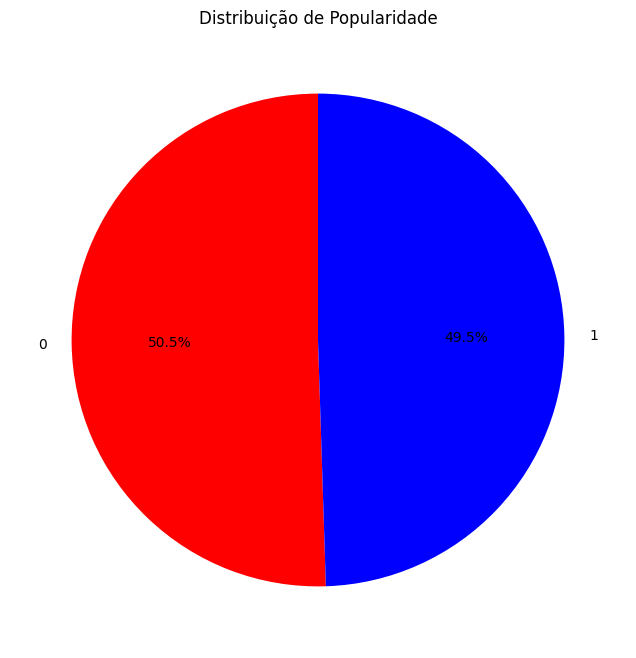

In [3247]:
# Contando os valores
sizes = df['popularity_target'].value_counts()
labels = df['popularity_target'].unique()

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'b'])

# Exibindo o gráfico
plt.title('Distribuição de Popularidade')
plt.show()

&ensp; Após a limpeza de duplicatas, verificou-se ainda maior balanceamento entre as classes.

## 3.3. Tratamento de Outliers

&ensp; O terceiro passo do processo de limpeza é o tratamento de outliers. Outliers são valores fora do padrão nos dados. Esses podem ser valores fora da faixa de valores permitida ou esperada.

### 3.3.1. Valores Fora da Faixa de Valores Permitida

&ensp; As colunas ``danceability``, ``energy``, ``acousticness``, ``instrumentalness``, ``liveness`` e ``valence`` estão normalizadas entre 0 e 1. Abaixo, verifica-se se este é o caso para todas as linhas.

In [3248]:
df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']].min()


danceability        0.000000
energy              0.000019
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
valence             0.000000
dtype: float64

In [3249]:
df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']].max()

danceability        0.985
energy              1.000
acousticness        0.996
instrumentalness    1.000
liveness            1.000
valence             0.995
dtype: float64

&ensp; A partir da verificação de máximo e mínimo, observa-se que essas colunas estão devidamente codificadas.

&ensp; Porém, outras colunas também têm faixas específicas.
- ``time_signature``: valores inteiros maiores que 1 e menores que 7
- ``key``: valores inteiros de 0 a 11 incluído
- ``loudness``: valores maiores que 0 e menores que 140
- ``tempo``: valores maiores que 0
- ``duration_ms``: valores maiores que 0
&ensp; Verifica-se, abaixo, essas colunas

#### 3.3.1.1. Time Signature

In [3250]:
df['time_signature'].value_counts()

time_signature
4    56394
3     5403
5     1117
1      601
0      100
Name: count, dtype: int64

&ensp; No caso apresentado acima verificou-se 701 músicas estranhas (``time_signature`` = 0 ou ``time_signature``= 1). Isso, pois, a assinatura de tempo representa o compasso da música, sendo que não pode ser representada por 0. Ademais, 1 é um valor incomum, pois representa uma batida constante. Verifica-se abaixo quais são algumas delas.

In [3251]:
df.loc[df['time_signature'] == df['time_signature'].isin([0,1])]

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
track_unique_id,,,,,,,,,,,,,,,,,,,
9313,ConeCrewDiretoria,Com os Neurônios Evoluidos,O Mundo Dá Voltas,279806,True,0.403,0.706,10,-6.046,0,0.3550,0.676000,0.00000,0.460,0.2700,77.224,1,brazil,1
42304,Fluoride,Disentanglement,Still Time,63769,False,0.220,0.985,8,-3.960,1,0.1090,0.000001,0.82200,0.353,0.0374,96.081,1,grindcore,0
98348,Laura Osnes,Anything Goes (New Broadway Cast Recording),"Goodbye, Little Dream, Goodbye",143720,False,0.236,0.145,5,-14.257,1,0.0409,0.946000,0.00509,0.155,0.0714,91.950,1,show-tunes,0
69478,Sadhu Kochu Kunju Upadesi,"Aswasageethangal, Vol. 1 (Christian Devotional...",Ente Daivam Mahathwathin,397613,False,0.731,0.381,0,-7.261,1,0.0276,0.487000,0.00000,0.306,0.6040,113.039,1,malay,0
62949,Jack Jones,Fiesta temática 60s,Mistletoe And Holly,101826,False,0.451,0.566,6,-10.766,1,0.0382,0.697000,0.00000,0.119,0.8470,98.439,1,j-pop,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621,Biosphere,Angel's Flight,Angel's Flight,352357,False,0.521,0.280,1,-16.645,1,0.0362,0.946000,0.94300,0.112,0.3070,141.960,1,ambient,1
56570,Akanksha Bhandari,Raahi,Amma Puchdi,264444,False,0.531,0.399,11,-9.089,1,0.0294,0.704000,0.00000,0.115,0.2100,107.506,1,indie-pop,1
65545,Yuvan Shankar Raja;Sriram Parthasarathy,Thangameenkal (Original Motion Picture Soundtr...,Aanandha Yaazhai,217000,False,0.768,0.335,10,-8.132,1,0.0378,0.784000,0.00000,0.105,0.6500,120.011,1,k-pop,1


&ensp; Algumas dessas músicas, como "Goodbye, Little Dream, Goodbye", "Mistletoe And Holly", e "Ente Daivam Mahathwathin" foram checadas e, apesar da falta de expertise musical do autor, pode-se verificar que elas foram incorretamente classificadas nestes casos.

&ensp; Entretanto, optou-se por não descartá-las, já que suas outras variáveis permanecem intactas e são relevantes para o modelo preditivo. Em caso de classificação incorreta de ``time_signature``, optou-se por aderir à moda 4. Isso, pois, 4/4 é o compasso comum (DESCOMPLICANDO A MÚSICA, 2014). Isso é feito abaixo.

In [3252]:
df.loc[df['time_signature'].isin([0,1]), 'time_signature'] = df['time_signature'].mode()[0]

#### 3.3.1.2. Key

&ensp; Abaixo, observa-se se os valores da coluna ``key`` correspondem a faixa de valores permitida.

In [3253]:
df['key'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

&ensp; Vê-se que a coluna key não contém outliers.

#### 3.3.1.3. Loudness

&ensp; Em nosso *DataFrame*, a coluna ``loudness`` diz respeito ao nível geral de volume da faixa em decibéis (dB). Sendo assim, sabe-se que este valor deve ser maior do que 0 e menor que 140 dB dado o contexto humano e musical. Verifica-se abaixo se todos os valores desta coluna estão nesta faixa.

In [3254]:
incorrect_loudness = df.loc[df['loudness'] <= 0].shape[0] + df.loc[df['loudness'] > 140].shape[0]
print(incorrect_loudness)

63573


&ensp; Há uma maioria esmagadora de valores fora desta faixa. Visualiza-se isto em um *pie plot* abaixo.

Text(0.5, 1.0, 'Pie Plot de Valores Corretos x Incorretos da Coluna Loudness')

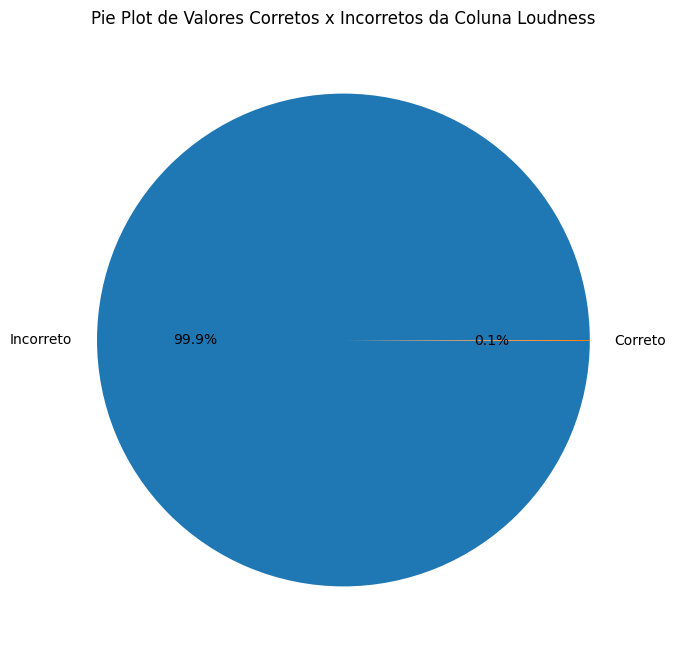

In [3255]:
plt.figure(figsize=(12,8))
plt.pie([incorrect_loudness, df.shape[0] - incorrect_loudness], labels=['Incorreto', 'Correto'], autopct='%1.1f%%')
plt.title('Pie Plot de Valores Corretos x Incorretos da Coluna Loudness')

&ensp; Sendo assim, esta coluna será excluída do *DataFrame*.

In [3256]:
df.drop(columns=['loudness'], inplace=True)

&ensp; Demonstra-se abaixo se o processo funcionou.

In [3257]:
df.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
track_unique_id,,,,,,,,,,,,,,,,,,
41996,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
76471,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
54809,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
16326,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
109799,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


&ensp; A coluna ``loudness`` foi retirada com sucesso.

#### 3.3.1.4. Tempo e Duração

&ensp; As colunas ``tempo`` e ``duration_ms``, por tratarem de duração de músicas, não podem conter valores abaixo de 0. O código abaixo verifica se isso acontece.

In [3258]:
df.loc[df['tempo'] <= 0].shape[0]

98

&ensp; Há 98 linhas que o ``tempo`` é menor ou igual a zero. No caso dessas, optou-se por substituí-las pela mediana, já que esta é menos sensível à outliers estátisticos que não foram ainda verificados.

In [3259]:
df.loc[df['tempo'] <= 0, 'tempo'] = df['tempo'].median()

&ensp; Investiga-se, agora, ``duration_ms``.

In [3260]:
df.loc[df['duration_ms'] <= 0].shape[0]

0

&ensp; Conclui-se que essa coluna não contém valores fora da faixa permitida.

#### 3.3.1.5 Valores Booleanos

&ensp; Apesar de a maioria dos algoritmos converter corretamente valores booleanos, escolheu-se convertê-los para dados do tipo ``int``, a fim de garantir a integridade do banco de dados.

&ensp; A variável ``mode`` é uma variável booleana que indica o modo (maior ou menor) da faixa. Em nosso DataFrame, porém, ela já é reconhecida como uma variável númerica.

In [3261]:
df['mode'].unique()

array([1, 0])

&ensp; Porém, a variável ``explicit`` ainda está identificada como booleana.

In [3262]:
df['explicit'].dtype

dtype('bool')

&ensp; Portanto, abaixo, converte-se esta variável para númerica.

In [3263]:
df['explicit'] = df['explicit'].astype(int)

&ensp; Verifica-se abaixo se o método funcionou.

In [3264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63615 entries, 41996 to 15795
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artists            63615 non-null  object 
 1   album_name         63615 non-null  object 
 2   track_name         63615 non-null  object 
 3   duration_ms        63615 non-null  int64  
 4   explicit           63615 non-null  int64  
 5   danceability       63615 non-null  float64
 6   energy             63615 non-null  float64
 7   key                63615 non-null  int64  
 8   mode               63615 non-null  int64  
 9   speechiness        63615 non-null  float64
 10  acousticness       63615 non-null  float64
 11  instrumentalness   63615 non-null  float64
 12  liveness           63615 non-null  float64
 13  valence            63615 non-null  float64
 14  tempo              63615 non-null  float64
 15  time_signature     63615 non-null  int64  
 16  track_genre        6361

&ensp; Tudo conforme o esperado.

#### 3.3.1.6. Strings alfabéticas

&ensp; Outra possibilidade de valores fora da faixa permitida são caracteres especiais ou númericos em strings que esperam somente letras de A-Z, sejam maiúsculas ou minúsculas. Para verificar isto, recorre-se novamente ao método ``info()``, com o propósito de verificar as colunas do tipo ``object``.

In [3265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63615 entries, 41996 to 15795
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artists            63615 non-null  object 
 1   album_name         63615 non-null  object 
 2   track_name         63615 non-null  object 
 3   duration_ms        63615 non-null  int64  
 4   explicit           63615 non-null  int64  
 5   danceability       63615 non-null  float64
 6   energy             63615 non-null  float64
 7   key                63615 non-null  int64  
 8   mode               63615 non-null  int64  
 9   speechiness        63615 non-null  float64
 10  acousticness       63615 non-null  float64
 11  instrumentalness   63615 non-null  float64
 12  liveness           63615 non-null  float64
 13  valence            63615 non-null  float64
 14  tempo              63615 non-null  float64
 15  time_signature     63615 non-null  int64  
 16  track_genre        6361

&ensp; Apesar de ``artists``, ``album_name``, ``track_name`` e `` track_genre`` serem do tipo ``object``, apenas ``artists`` não pode conter números. Normalmente, ele também não conteria caracteres especiais, porém, é comum que nomes sejam abreviados com pontos. Além disso, em casos de feat, esta coluna contém o caractere especial ";". Por essa razão, verifica-se abaixo se há algum número nesta coluna.

In [3266]:
# Regex para identificar strings que contenham números
regex_pattern = r'\d'

# Verificar se há caracteres fora do padrão na coluna 'artists'
df['artists'].str.contains(regex_pattern, regex=True, na=False).sum()

np.int64(1702)

&ensp; Há uma quantidade significativa de nomes com números. Investiga-se abaixo alguns deles.

In [3267]:
df.loc[df['artists'].str.contains(regex_pattern, regex=True, na=False)]

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
track_unique_id,,,,,,,,,,,,,,,,,,
74052,UM44K;Luan Otten,Melhor pensar,Melhor pensar,205345,0,0.665,0.431,8,1,0.0306,0.416000,0.000000,0.1740,0.698,149.935,4,mpb,1
23204,Y.V.E. 48,Let You Know,Let You Know,173166,0,0.610,0.571,5,1,0.0395,0.242000,0.210000,0.2280,0.147,89.769,4,deep-house,1
15612,creamy;Martin Arteta;11:11 Music Group,Past Lives,Past Lives (Acoustic),122586,0,0.601,0.330,3,1,0.0336,0.981000,0.015900,0.3550,0.461,116.058,4,chill,1
77369,Atitude 67,Atitude 67 (Ao Vivo),Vou Te Escrever Um Rap - Ao Vivo,190440,0,0.712,0.823,9,1,0.0859,0.561000,0.000000,0.7670,0.765,161.885,4,pagode,1
91175,blink-182,Halloween Scary Party,Ghost On The Dance Floor,257519,1,0.532,0.969,11,1,0.0581,0.000024,0.026500,0.0912,0.547,103.511,4,rock,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33159,6ix9ine,Day69: Graduation Day,GOTTI,166851,1,0.728,0.584,10,0,0.1760,0.052400,0.000000,0.0658,0.365,161.900,4,emo,1
61228,Keyakizaka46,真っ白なものは汚したくなる (Complete Edition),バレエと少年,221560,0,0.679,0.556,7,0,0.0297,0.210000,0.000000,0.2190,0.435,120.004,4,j-idol,0
2747,La 25,Asi Es el Rock And Roll,Mil Canciones,372091,0,0.568,0.851,7,1,0.0327,0.025000,0.000000,0.0763,0.490,124.035,4,alt-rock,1


&ensp; Após investigação, verificou-se que o senso comum de nomes não conterem letras não se aplica aos nomes artísticos. Isso, pois podem haver bandas com números em seus nomes como o "The 20 Belows" e, até mesmo, nomes artísticos como "6ix9ine". Sendo assim, optou-se por manter esses registros.

&ensp; Nesta seção, nenhum registro foi retirado, de modo que o balanceamento entre as classes permanece igual. Entretanto, valores fora da faixa de valores permitida foram substituídas pela sua moda ou mediana a depender do contexto.

### 3.3.2. Valores fora da faixa de valores esperada

&ensp; Para este projeto, considerou-se outliers os valores neste formato: $Q_3 + 1.5 \cdot IQR$ ou $Q_1 - 1.5 \cdot IQR$ em que:
- $Q_n$ é o quartil n;
- $IQR$ é o intervalo interquartil.
&ensp; Entretanto, evidencia-se que a natureza dos dados permite apenas que ``tempo`` e ``duration_ms`` possam ter valores assim. Verifica-se a quantidade de outliers por meio do *box plot* abaixo.

Text(0.5, 0, 'Duração(ms)')

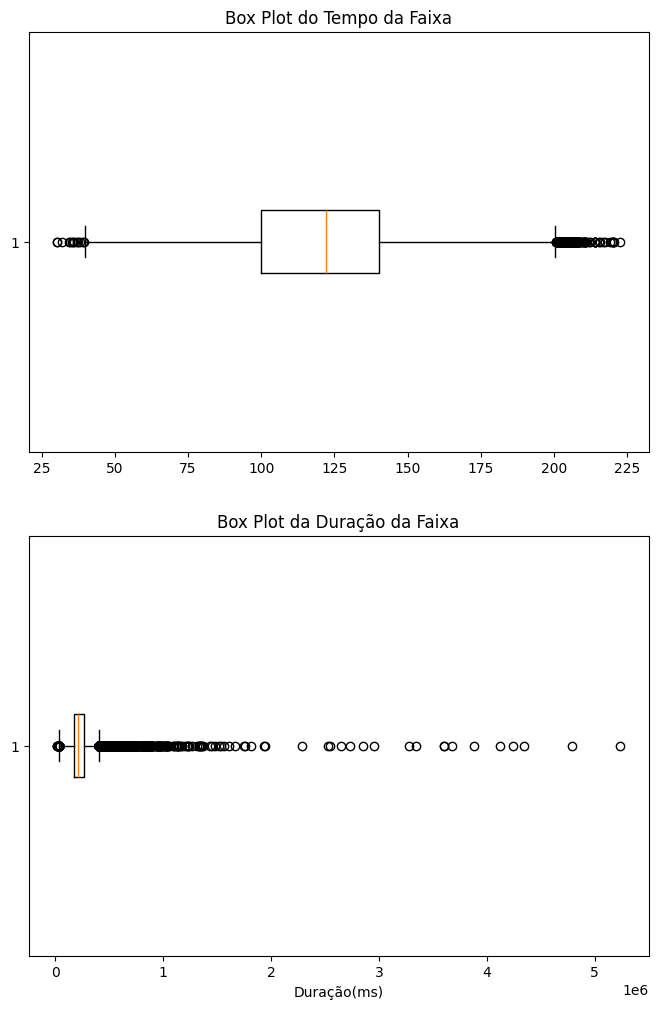

In [3268]:
fig, axs = plt.subplots(2, 1, figsize=(8,12))

axs[0].boxplot(df['tempo'], vert=False)
axs[0].set_title('Box Plot do Tempo da Faixa')

axs[1].boxplot(df['duration_ms'], vert=False)
axs[1].set_title('Box Plot da Duração da Faixa')
axs[1].set_xlabel('Duração(ms)')


&ensp; Em ambos os casos, optou-se por substituir esses valores pelos valores do terceiro ou do primeiro quartil a depender se o outlier é superior ou inferior. Faz-se isso abaixo

In [3269]:
# Cálculo do IQR
iqr = df['tempo'].quantile(0.75) - df['tempo'].quantile(0.25)
q1 = df['tempo'].quantile(0.25)
q3 = df['tempo'].quantile(0.75)

# Substituindo outliers superiores
df.loc[df['tempo'] >= (q3 + 1.5 * iqr), 'tempo'] = q3

# Substituindo outliers inferiores
df.loc[df['tempo'] <= (q1 - 1.5 * iqr), 'tempo'] = q1



In [3270]:
# Cálculo do IQR
iqr = df['duration_ms'].quantile(0.75) - df['duration_ms'].quantile(0.25)
q1 = df['duration_ms'].quantile(0.25)
q3 = df['duration_ms'].quantile(0.75)

# Substituindo outliers superiores
df.loc[df['duration_ms'] >= (q3 + 1.5 * iqr), 'duration_ms'] = q3

# Substituindo outliers inferiores
df.loc[df['duration_ms'] <= (q1 - 1.5 * iqr), 'duration_ms'] = q1

&ensp; Abaixo, verifica-se se isto funcinou.

Text(0.5, 0, 'Duração(ms)')

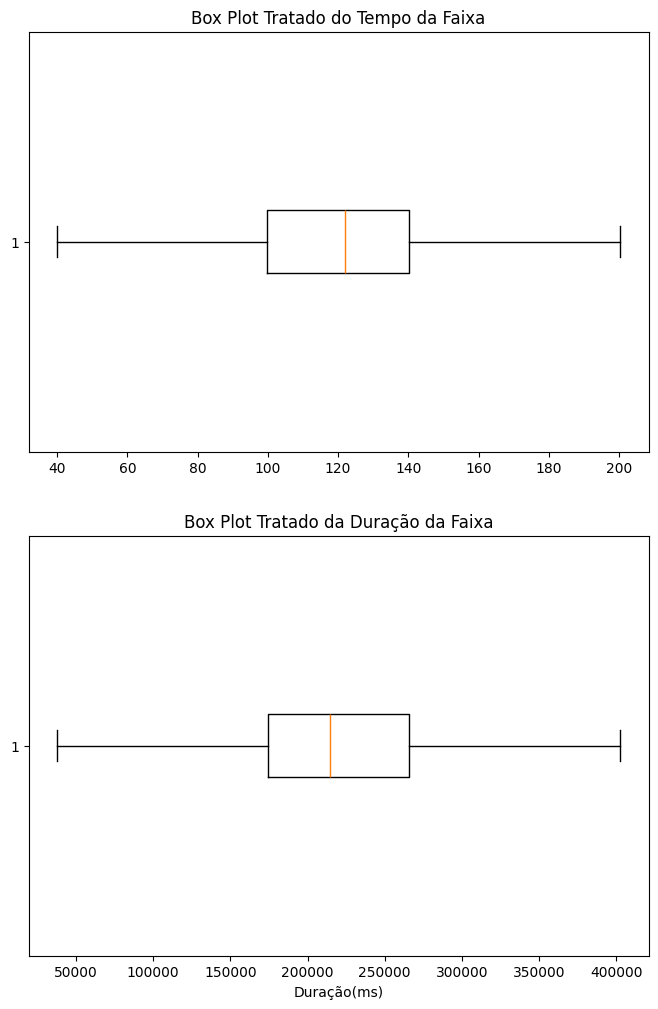

In [3271]:
fig, axs = plt.subplots(2, 1, figsize=(8,12))

axs[0].boxplot(df['tempo'], vert=False)
axs[0].set_title('Box Plot Tratado do Tempo da Faixa')

axs[1].boxplot(df['duration_ms'], vert=False)
axs[1].set_title('Box Plot Tratado da Duração da Faixa')
axs[1].set_xlabel('Duração(ms)')

&ensp; Observa-se que o processo funcionou.

## 3.4. Considerações finais

&ensp; Este processo de limpeza permitiu tratar os outliers e retirar duplicatas de nosso *DataFrame*. Não obstante, manteve-se o balanceamento das classes e a integridade do mesmo. Antes de fechar a seção, porém, é necessário excluir a coluna ``track_name``, que também possui muitos valores únicos, mas que não poderia ser retirada no processo de duplicatas já que diferenciava efetivamente as músicas. Faz-se isso abaixo

In [3272]:
df.drop(columns='track_name', inplace=True)

df.head()

,artists,album_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
track_unique_id,,,,,,,,,,,,,,,,,
41996,Love and Rockets,Love and Rockets,211533,0,0.305,0.8490,9,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
76471,Filippa Giordano,Filippa Giordano,196000,0,0.287,0.1900,7,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
54809,Susumu Yokota,Symbol,216506,0,0.583,0.5090,1,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
16326,Franz Liszt;YUNDI,Relajación y siestas,218346,0,0.163,0.0368,8,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
109799,Scooter,Scooter Forever,173160,0,0.647,0.9210,2,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


&ensp; Desta forma, finaliza-se o processo de limpeza.

# 4. Processo 3: Teste de Hipóteses

&ensp; Ao fim da seção de Exploração Inicial de Dados, expôs-se três hipóteses acerca da interação entre as variáveis e a coluna popularidade. Repete-se aqui estas hipóteses:

1. Apesar de nenhuma variável númerica da música, por si, r a popularidade da música, sugere-se que uma combinação de variáveis o faça. Portanto, hipotetiza-se que um conjunto de variáveis feliz, como alta ``valence``, alta ``energy`` e alta ``danceability`` contenha mais músicas populares do que não populares;

2. Espera-se que o autor(a) da música influencie mais na popularidade da música do que suas características musicais. Portanto, hipotetiza-se que a maioria das músicas do The Beatles sejam populares;

3. Dado que o gênero de música mais recorrente é "progressive-house", sugere-se que o gênero de uma música não é relevante para sua popularidade. Portanto, hipotetiza-se que o desvio padrão entre a porcentagem de músicas populares seja baixo (<20%).

Nesta seção, após a limpeza, estas hipóteses serão testadas.

## 4.1. Felicidade x Popularidade

&ensp; A primeira hipótese era que músicas definidas como felizes (``valence > 0.5``, ``energy > 0.5`` e ``danceability > 0.5``) conteriam mais músicas populares do que não populares. Testemos isto abaixo. Primeiro, deve-se verificar se existem músicas com esses traços

In [3273]:
musicas_felizes = df.loc[(df['valence'] > 0.5) & (df['energy'] > 0.5) & (df['danceability'] > 0.5)]

print(musicas_felizes.shape[0])

19654


&ensp; Existem 19654 músicas consideradas felizes. Vejamos agora quantas delas são também populares

In [3274]:
musicas_felizes['popularity_target'].sum()

np.int64(9816)

&ensp; Utilizando-se um gráfico de barras, pode-se visualizar até que ponto músicas felizes contém mais músicas populares que não.

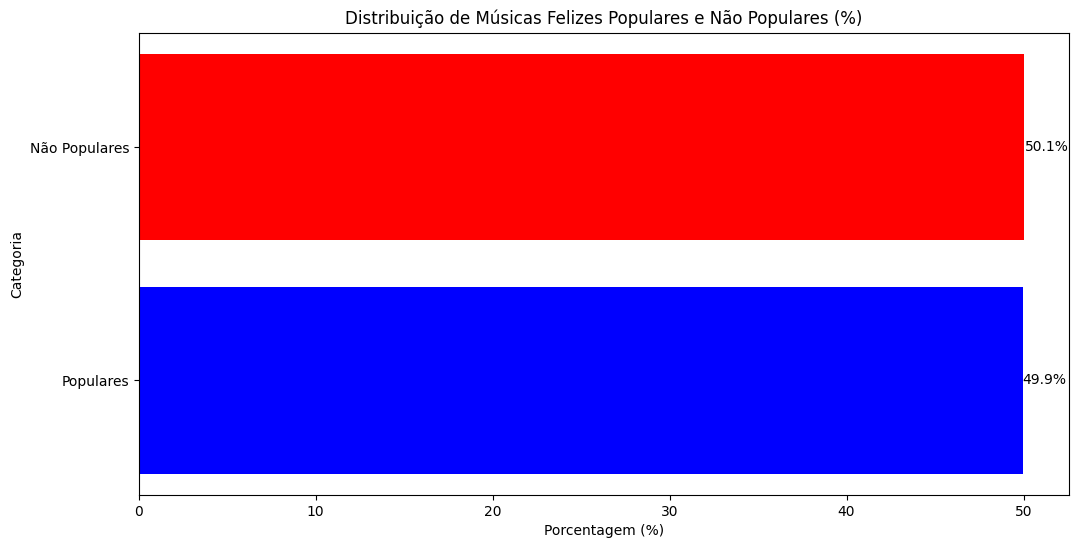

In [3275]:
plt.figure(figsize=(12,6))
populares = musicas_felizes['popularity_target'].sum()
nao_populares = musicas_felizes.shape[0] - populares

# Calcular total e porcentagens
total = musicas_felizes.shape[0]
porcentagem_populares = (populares / total) * 100
porcentagem_nao_populares = (nao_populares / total) * 100

plt.barh(['Populares', 'Não Populares'], [porcentagem_populares, porcentagem_nao_populares], color=['blue', 'red'])
plt.title('Distribuição de Músicas Felizes Populares e Não Populares (%)')
plt.ylabel('Categoria')
plt.xlabel('Porcentagem (%)')

# Adicionar os rótulos das porcentagens nas barras
for index, value in enumerate([porcentagem_populares, porcentagem_nao_populares]):
    plt.text(value, index, f'{value:.1f}%', va='center')

plt.show()

&ensp; Não é necessário provar o quão correta está esta hipótese, pois ela está incorreta. Apesar de por pequena margem, há mais músicas felizes não populares do que populares. Deve-se notar, entretanto, que enquanto na população há 49.5% de músicas populares, nesta amostra feliz há 49.9% mesmo que isso não seja estatisticamente relevante.

## 4.2. The Beatles x Popularidade

&ensp; A segunda hipótese dizia respeito à maior relevância do(a) artista para a popularidade de uma música comparado à variáveis como "dançabilidade" e "acusticidade". Dado as limitações deste trabalho, optou-se por utilizar como prova apenas os dados da banda mais recorrente em nosso banco de dados: The Beatles. Assim, espera-se que as músicas da banda The Beatles tenham maior probabilidade de serem populares do que não. 

In [3276]:
beatles_musica = df.loc[df['artists'] == artist_mode]

beatles_musica.shape[0]

129

&ensp; Após a limpeza sobraram 129 faixas do The Beatles no banco. Isso evidencia a importância da limpeza, pois anteriormente haviam 65 faixas a mais que estavam incorretas. Agora, verifica-se a popularidade das músicas dos Beatles.

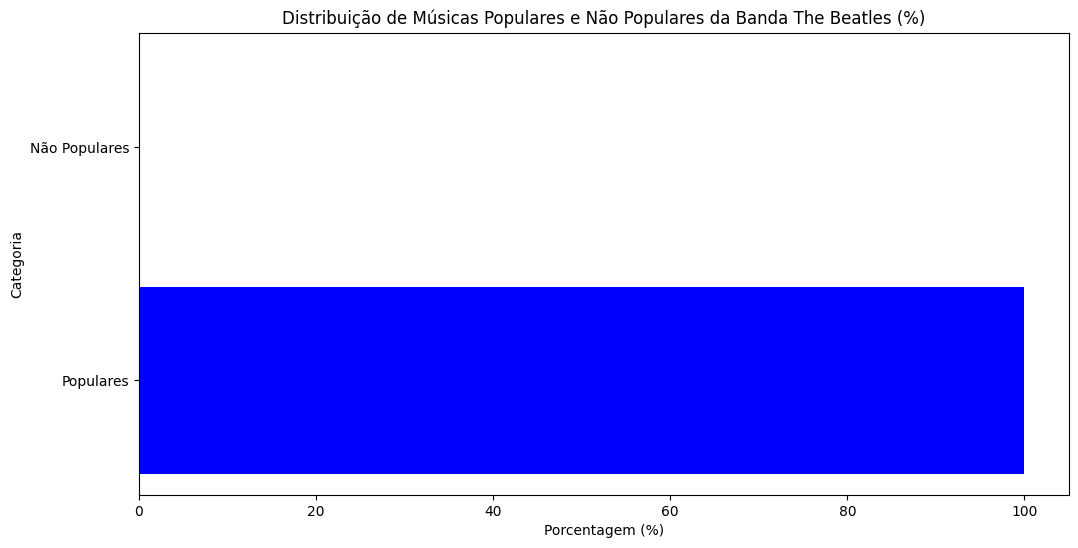

In [3277]:
plt.figure(figsize=(12,6))
populares = beatles_musica['popularity_target'].sum()
nao_populares = beatles_musica.shape[0] - populares

# Calcular total e porcentagens
total = beatles_musica.shape[0]
porcentagem_populares = (populares / total) * 100
porcentagem_nao_populares = (nao_populares / total) * 100

plt.barh(['Populares', 'Não Populares'], [porcentagem_populares, porcentagem_nao_populares], color=['blue', 'red'])
plt.title('Distribuição de Músicas Populares e Não Populares da Banda The Beatles (%)')
plt.ylabel('Categoria')
plt.xlabel('Porcentagem (%)')


plt.show()

&ensp; Neste caso, não há dúvidas acerca da veracidade da hipótese. 100% das músicas da banda The Beatles são populares, não obstante a variação de suas características como pode ser visto abaixo.

(0.0, 1.0)

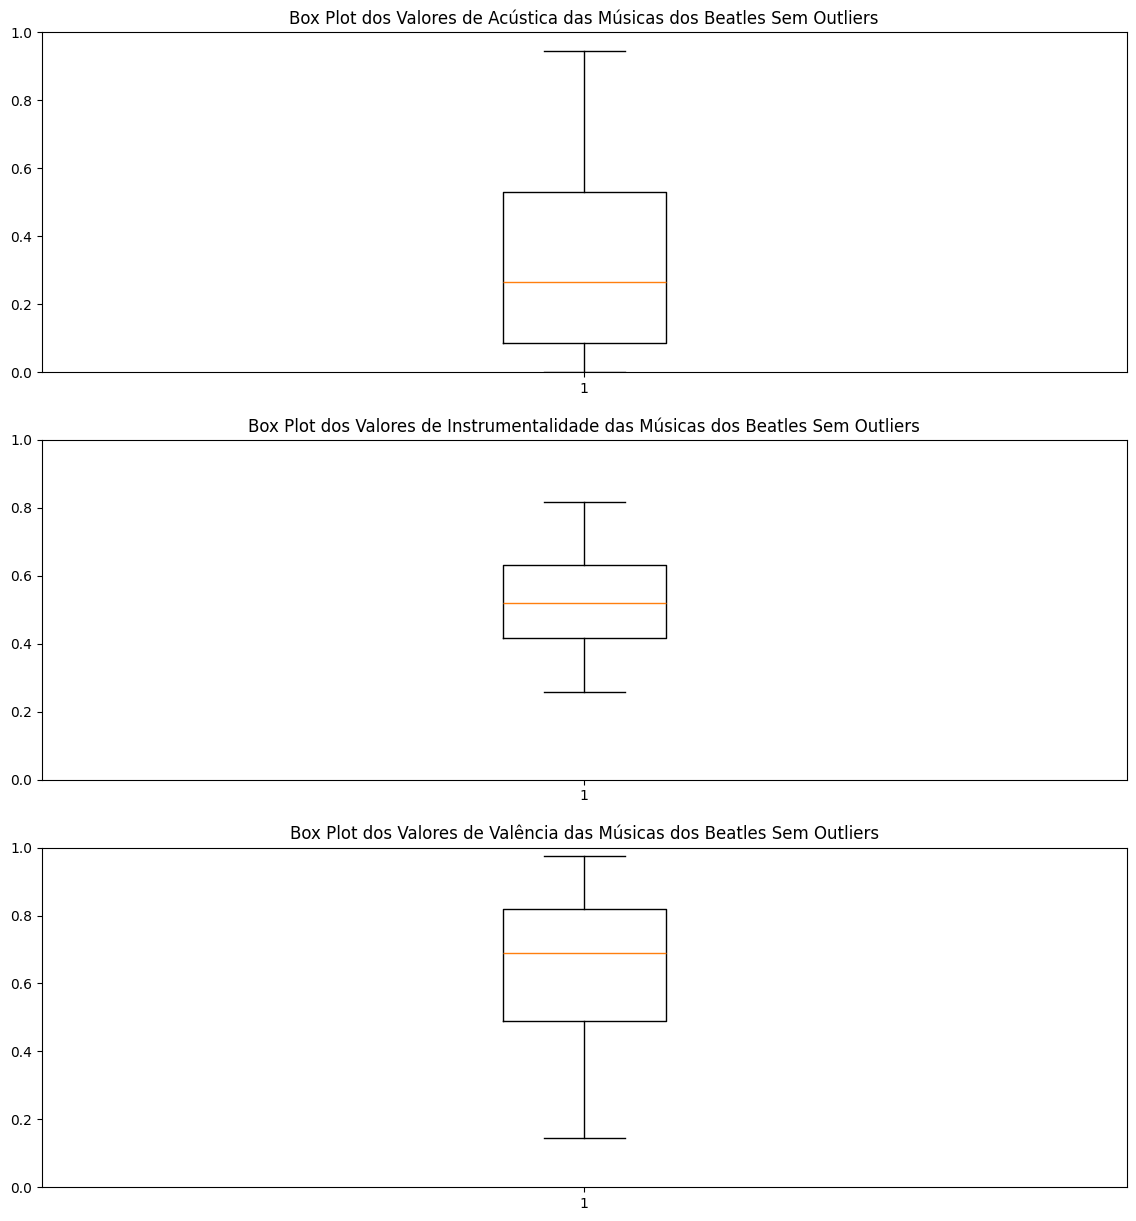

In [3278]:
fig, axs = plt.subplots(3, 1, figsize=(14,15))

axs[0].boxplot(beatles_musica['acousticness'], showfliers=False)
axs[0].set_title('Box Plot dos Valores de Acústica das Músicas dos Beatles Sem Outliers')
axs[0].set_ylim(0, 1)  # Definindo a escala de 0 a 1

axs[1].boxplot(beatles_musica['danceability'], showfliers=False)
axs[1].set_title('Box Plot dos Valores de Instrumentalidade das Músicas dos Beatles Sem Outliers')
axs[1].set_ylim(0, 1)

axs[2].boxplot(beatles_musica['valence'], showfliers=False)
axs[2].set_title('Box Plot dos Valores de Valência das Músicas dos Beatles Sem Outliers')
axs[2].set_ylim(0, 1)

&ensp; Há músicas muito dançantes e pouquíssimo dançantes; há músicas que não são nenhum pouco acústicas e outras que são quase 100% acústicas e não obstante, todas são populares. Infere-se, a partir disso, que qualquer música dos Beatles seria popular. Induz-se também que o nome do artista tenha mais influência do que qualquer outra variável que diga respeito à música.

## 4.3. Familiaridade x Popularidade

&ensp; Na tentativa de encontrar variáveis mais significativas nos dados, hipotetizou-se acerca da  influência da familiariadade do artista para a popularidade. Espera-se que quanto mais música um artista tiver registrada na base de dados, maior a chance dele ser popular. Sendo assim, criou-se a hipotése que o indíce de familiaridade definida por ``quantidade de músicas do artista/quantidade média de música por artista`` teria uma maior correlação com a popularidade que os outros indíces. Para verificar isso, é necessário primeiro criar essa coluna no *DataFrame*.

In [3279]:
# Passo 1: Contar o número de músicas de cada artista
musicas_por_artista = df['artists'].value_counts()

# Passo 2: Calcular a quantidade média de músicas por artista
media_musicas_por_artista = musicas_por_artista.mean()

# Passo 3: Criar a nova coluna 'familiar_artists'
df['familiar_artists'] = df['artists'].map(lambda x: musicas_por_artista[x] / media_musicas_por_artista)

In [3280]:
df.head()

,artists,album_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target,familiar_artists
track_unique_id,,,,,,,,,,,,,,,,,,
41996,Love and Rockets,Love and Rockets,211533,0,0.305,0.8490,9,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0,0.405172
76471,Filippa Giordano,Filippa Giordano,196000,0,0.287,0.1900,7,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0,2.836202
54809,Susumu Yokota,Symbol,216506,0,0.583,0.5090,1,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1,6.887920
16326,Franz Liszt;YUNDI,Relajación y siestas,218346,0,0.163,0.0368,8,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0,0.405172
109799,Scooter,Scooter Forever,173160,0,0.647,0.9210,2,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0,40.112002


&ensp; Agora, verifica-se a correlação das colunas com a target para comparação

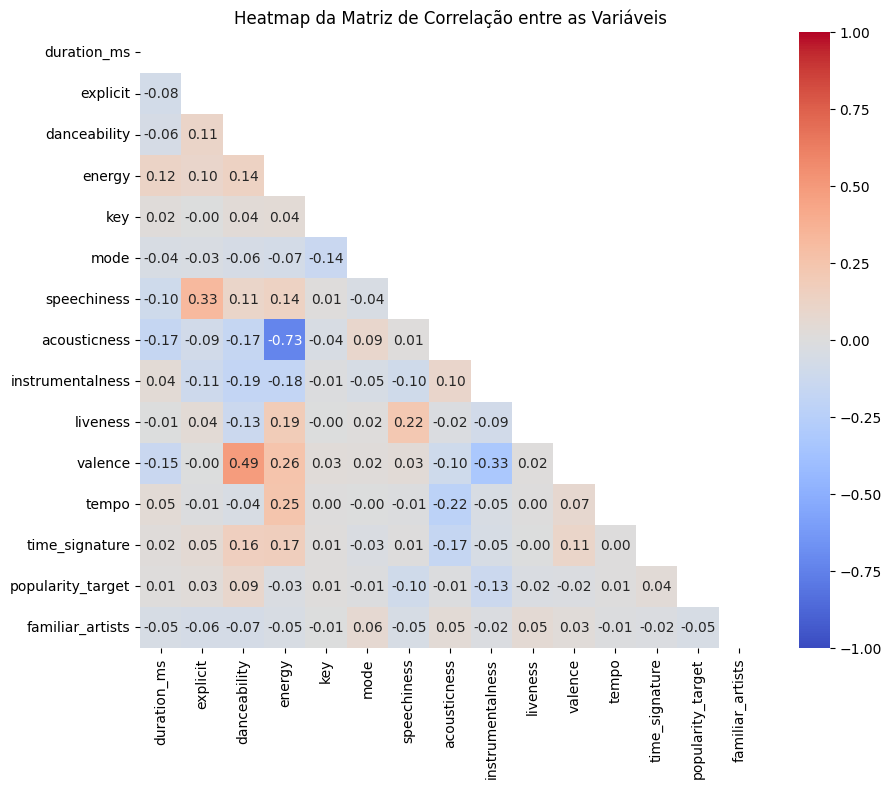

In [3281]:
corr = df.select_dtypes(include='number').corr()

mask = mask = np.triu(np.ones_like(corr, dtype=bool))

# Criando o heatmap
plt.figure(figsize=(10, 8))  # Ajustando o tamanho do gráfico
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

# Exibindo o gráfico
plt.title('Heatmap da Matriz de Correlação entre as Variáveis')
plt.show()

&ensp; Comparando-se a correlação de ``familiar_artists`` com ``popularity_target`` acima, observou-se que essa coluna era, na verdade, menos correlacionada com a popularidade do que a maioria das outras. Deste modo, a hipótese se provou incorreta. Porém, a coluna permanecerá para fins de teste do modelo.

# 5. Processo 4: Normalização e Codificação das Variáveis

&ensp; Em tratando-se de aprendizado de máquina, em vias de melhorar a performance de um modelo, aplica-se normalmente à mesma escala à todas as variáveis númericas. Para isso, pode-se utilizar métodos como o MinMax Scaler e o Standard Scaler do Scikit-Learn. Ademais, deve-se compreender que a maioria dos algoritmos não consegue discernir variáveis categóricas. Por essa razão, é essencial transformar quaisquer variáveis categóricas em númericas. Para tanto, normalmente utiliza-se o One-Hot Encoding ou o Label Encoder. Porém, outros métodos podem ser aplicados. Esses dois processos são chamados, respectivamente, normalização e codificação e são demonstrados abaixo. 

## 5.1. Normalização

&ensp; Neste projeto, grande parte das colunas númericas já estão normalizadas em uma escala entre 0 e 1. As únicas exceções são ``duration_ms``, ``key``, ``tempo``, ``familiar_artists`` e ``time_signature``. Aplica-se abaixo o MinMaxScaler em cada uma delas

In [3282]:
scaler = MinMaxScaler()

In [3283]:
#MinMaxScaler em duration_ms
df['duration_ms'] = scaler.fit_transform(df[['duration_ms']])

In [3284]:
#MinMaxScaler em key
df['key'] = scaler.fit_transform(df[['key']])

In [3285]:
#MinMaxScaler em tempo
df['tempo'] = scaler.fit_transform(df[['tempo']])

In [3286]:
#MinMaxScaler em time_signature
df['time_signature'] = scaler.fit_transform(df[['time_signature']])

In [3287]:
df['familiar_artists'] = scaler.fit_transform(df[['familiar_artists']])

In [3288]:
df.head()

,artists,album_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target,familiar_artists
track_unique_id,,,,,,,,,,,,,,,,,,
41996,Love and Rockets,Love and Rockets,0.476456,0,0.305,0.8490,0.818182,1,0.0549,0.000058,0.056700,0.4640,0.3200,0.634891,0.5,goth,0,0.000000
76471,Filippa Giordano,Filippa Giordano,0.433900,0,0.287,0.1900,0.636364,0,0.0370,0.930000,0.000356,0.0834,0.1330,0.272922,0.5,opera,0,0.033520
54809,Susumu Yokota,Symbol,0.490081,0,0.583,0.5090,0.090909,1,0.0362,0.777000,0.202000,0.1150,0.5440,0.315119,0.0,idm,1,0.089385
16326,Franz Liszt;YUNDI,Relajación y siestas,0.495122,0,0.163,0.0368,0.727273,1,0.0472,0.991000,0.899000,0.1070,0.0387,0.184199,0.0,classical,0,0.000000
109799,Scooter,Scooter Forever,0.371325,0,0.647,0.9210,0.181818,1,0.1850,0.000939,0.371000,0.1310,0.1710,0.611145,0.5,techno,0,0.547486


&ensp; Agora, todas as colunas numéricas estão devidamente normalizadas.

## 5.2. Codificação de Variáveis

&ensp; A codificação das variáveis pode ser feita de diferentes formas. Uma delas é transformar cada um dos possíveis valores únicos de uma coluna categórica em uma coluna utilizando o One-Hot Enconding. Entretanto, este nível de detalhe no contexto musical atrapalha a generalização do modelo preditivo, pois pode causar a "Maldição da Dimensionalidade". Outra maneira é associar cada um dos valores únicos a um código, esta é a forma que o Label Encoder lida com a transformação de variáveis categóricas em númericas. Entretanto, essa maneira pressupõe uma ordem nos dados que não existe nos casos das variáveis categóricas presentes. 

&ensp; Sendo assim, optou-se por uma forma diferente de codificação. Substituir-se-á os valores nas colunas ``artists``, ``album_name`` e ``track_genre`` pela probabilidade desses valores serem populares. Isso pode parecer improdutivo, já que geraria um overfit nos dados. Entretanto, deve-se considerar que se trata apenas de uma probabilidade e que, portanto, é incapaz de afirmar com certeza se um dado é ou não popular.

&ensp; Esta solução foi criada para integrar ao modelo a conclusão tirada na hipótese 2 proposta neste documento: o artista é muito mais importante que as características musicais. No entanto, deve-se considerar três fatores para a sua implementação. Esses fatores são esboçados abaixo usando o exemplo do nome do artista:

1. Se todas as músicas de um artista no banco de dados são populares, então a probabilidade associada ao seu nome será 1, mesmo que se trate de um artista pequeno em que apenas uma música ficou famosa.
2. Se todas as músicas de um artista no banco de dados não são populares, então a probabilidade associada ao seu nome será 0, mesmo que se tomadas outras músicas em consideração haja músicas populares deste artista.
3. Artistas pequenos terão probabilidades super-dimensionadas no banco de dados.

&ensp; Ponderando acerca desses fatores e na tentativa de não gerar um overfit no modelo, resolveu-se por adicionar 1 no numerador do cálculo da probabilidade (nenhum artista terá probabilidade zero) e 2 no denominador (nenhum artista terá probabilidade igual a 1). Esta forma de codificação é feita abaixo

In [3289]:
def codificador_probabilidade(df, nome_coluna, target):
    resultado = df.groupby(nome_coluna).apply(
        lambda x: ((x[target].sum() + 1) / (len(x) + 2) ) 
    ).rename('percentual_popular')
    return resultado

&ensp; Após criar essa função codificadora, cria-se três *DataFrames* para referência e transforma-se as colunas no `df` original.

In [3290]:
resultado_artists = codificador_probabilidade(df, 'artists', 'popularity_target')
resultado_album_name = codificador_probabilidade(df, 'album_name', 'popularity_target')
resultado_track_genre = codificador_probabilidade(df, 'track_genre', 'popularity_target')

C:\Users\Inteli\AppData\Local\Temp\ipykernel_17132\3490878094.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultado = df.groupby(nome_coluna).apply(
C:\Users\Inteli\AppData\Local\Temp\ipykernel_17132\3490878094.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultado = df.groupby(nome_coluna).apply(
C:\Users\Inteli\AppData\Local\Temp\ipykernel_17132\3490878094.py:2: DeprecationWarning: DataFram

In [3291]:
df['artists'] = df['artists'].map(resultado_artists)
df['album_name'] = df['album_name'].map(resultado_album_name)
df['track_genre'] = df['track_genre'].map(resultado_track_genre)

&ensp; Esses processos de normalização resultaram no seguinte `df`.

In [3292]:
df.head()

,artists,album_name,duration_ms,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target,familiar_artists
track_unique_id,,,,,,,,,,,,,,,,,,
41996,0.333333,0.333333,0.476456,0,0.305,0.8490,0.818182,1,0.0549,0.000058,0.056700,0.4640,0.3200,0.634891,0.5,0.191104,0,0.000000
76471,0.111111,0.250000,0.433900,0,0.287,0.1900,0.636364,0,0.0370,0.930000,0.000356,0.0834,0.1330,0.272922,0.5,0.169231,0,0.033520
54809,0.315789,0.750000,0.490081,0,0.583,0.5090,0.090909,1,0.0362,0.777000,0.202000,0.1150,0.5440,0.315119,0.0,0.096183,1,0.089385
16326,0.333333,0.043478,0.495122,0,0.163,0.0368,0.727273,1,0.0472,0.991000,0.899000,0.1070,0.0387,0.184199,0.0,0.114447,0,0.000000
109799,0.069307,0.200000,0.371325,0,0.647,0.9210,0.181818,1,0.1850,0.000939,0.371000,0.1310,0.1710,0.611145,0.5,0.650391,0,0.547486


&ensp; A próxima etapa, portanto, é a seleção de features.

# 6. Processo 5: Seleção de Features

&ensp; Após normalizar todas as variáveis, começamos o processo de seleção de feature. Esse processo pode ser feito com base nas correlações encontradas anteriormente, porém elas não revelaram resultados significativos. Nesse sentido, preferiu-se utilizar o método `mutual_info_classif()`, o qual utiliza aspectos da teoria da informação para calcular a informação mútua entre variáveis independentes (features) e o alvo (target). Desta forma, ele calcula um *score* para cada variável que vai de 0 à 1. Vê-se a aplicação deste método abaixo.

In [3293]:
# Cria uma cópia do df para selecionar as features
df_train = df.copy()

In [3294]:
y = df_train['popularity_target']
X = df_train.drop(columns='popularity_target')

In [3295]:
feature_scores = mutual_info_classif(X, y, discrete_features=[3, 7], random_state=42, n_jobs=-1)

feature_wscores = pd.DataFrame({
    'Feature': X.columns,  # Nome das colunas (features)
    'MI_Score': feature_scores   # Escores de informação mútua
})

feature_wscores = feature_wscores.sort_values(by='MI_Score', ascending=False)

print(feature_wscores)

             Feature  MI_Score
1         album_name  0.618258
0            artists  0.509244
15       track_genre  0.232707
16  familiar_artists  0.023662
2        duration_ms  0.016554
13             tempo  0.016049
9       acousticness  0.015872
5             energy  0.012337
10  instrumentalness  0.010741
4       danceability  0.010633
14    time_signature  0.009350
8        speechiness  0.008713
12           valence  0.001440
11          liveness  0.000977
3           explicit  0.000345
7               mode  0.000089
6                key  0.000000


&ensp; Os resultados acima estão em ordem de *feature* mais informativa para *feature* menos informativa. Entretanto, deve-se notar que devido à codificação feita (baseada na probabilidade), eram esperadas as primeiras três variáveis. Isso, provavelmente não será o caso para o conjunto de testes, no qual nem todos os artistas presentes nesta base estão presentes naquela. Sendo assim, para não enviesar a predição, usar-se-á as primeiras 8 features (5 sem vieses e 3 com viés). Estas são:

In [3296]:
feature_wscores['Feature'][:8]

1           album_name
0              artists
15         track_genre
16    familiar_artists
2          duration_ms
13               tempo
9         acousticness
5               energy
Name: Feature, dtype: object

In [3297]:
X = X.drop(columns=['instrumentalness', 'speechiness', 'danceability', 'time_signature',  'valence', 'liveness', 'explicit', 'mode', 'key'])

# 7. Processo 6: Construção e Avaliação do Modelo

&ensp; Para este projeto, foi selecionado o modelo Random Forest habilitado pelo Scikit-Learn. Esse método combina diversas Decision Trees e escolhe, para cada predição, o resultado mais frequente (SCIKIT-LEARN, 2018). Além disso, esse modelo possui alta explicabilidade, o que auxilia o processo de apresentação de resultados. Abaixo, verifica-se a aplicação dele em nosso conjunto de dados.

&ensp; Primeiro, é necessário separar parte do banco de dados para teste. Uma maneira de fazer isso é usando o método `train_test_split()` do Scikit-Learn.

In [3298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

&ensp; Subsequentemente, aplica-se o modelo.

In [3299]:
clf = RandomForestClassifier(max_depth=2, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

&ensp; Para a avaliação do modelo, abaixo, faz-se uma matriz de confusão, um relatório das métricas e o resultado da acurácia final.

In [3300]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10632
           1       0.98      0.97      0.97     10361

    accuracy                           0.97     20993
   macro avg       0.97      0.97      0.97     20993
weighted avg       0.97      0.97      0.97     20993



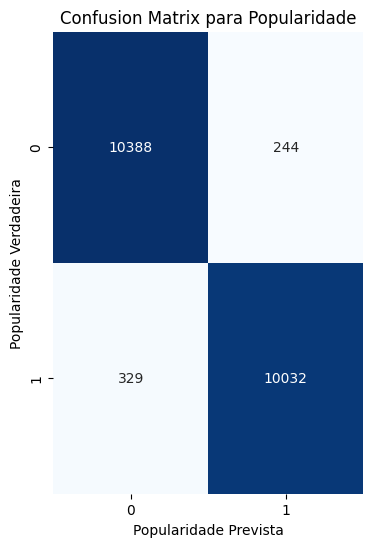

In [3301]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels and title
plt.xlabel('Popularidade Prevista')
plt.ylabel('Popularidade Verdadeira')
plt.title('Confusion Matrix para Popularidade')
plt.show()

In [3302]:
print(accuracy_score(y_test, y_pred))

0.9727051874434335


&ensp; Baseado nas métricas exibidas, vê-se que o resultado da acurácia foi ótimo: 97.3%. Além disso, o alto valor para precisão identifica que o modelo é capaz de classificar corretamente 97.5% das classes positivas, ou seja, há poucos falsos positivos. A sensibilidade do modelo, por sua vez, expõe que ele foi muito bom em identificar instâncias positivas, de modo que há poucos falso negativos. Essas altas métricas compostas explicam o alto valor do F1-Score de 97%, o qual representa a média harmônica entre precisão e sensibilidade. Conclui-se, portanto, que este foi um ótimo modelo. Entretanto, para melhorá-lo ainda mais, faz-se o ajuste de hiperparâmetros abaixo.

# 8. Processo 7: Ajuste de Hiperparâmetros

&ensp; Para o ajuste de hiperparâmetros, pode-se usar dois métodos do Scikit-Learn: o GridSearch e o Randomized Search. O primeiro faz uma busca exaustiva no intervalo passado pelo usuário. Já o segundo faz uma busca aleatória no intervalo passado. Para este projeto, optou-se pelo segundo, dado que este modelo já apresenta ótimos resultados, o que não compensaria o alto poder computacional necessário para o primeiro. Faz-se esse proceso abaixo.

&ensp; O RandomForest possui os seguintes hiperparâmetros principais:
- n_estimators - Define o número de Decision Trees do modelo;
- criterion - Define a função que mede a qualidade do modelo. Os possíveis valores são "gini", "entropy" e "log_loss";
- max_depth - Define a profundidade máxima de uma Decision Tree;
- min_samples_split - Define o número mínimo de amostras para dividir um nó;

&ensp; Abaixo, testa-se diferentes combinações deles.

In [3303]:
parametros =  { 
    'n_estimators': np.arange(10, 200, 50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(3, 10, 1),
    'min_samples_split': [2, 5, 10], 
}

clf_ajustado = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=clf_ajustado, 
    param_distributions=parametros, 
    n_iter=100, 
    cv=3, 
    verbose=3,  # exibir progresso no terminal
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Melhores parâmetros:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores parâmetros: {'n_estimators': np.int64(110), 'min_samples_split': 5, 'max_depth': np.int64(9), 'criterion': 'entropy'}


&ensp; Após obter os melhores hiperparâmetros, testa-se novamente no modelo para se obter novas métricas e verificar que se funcionou o ajuste. Caso não tenha funcionado, manteremos o modelo sem ajustes encontrado anteriormente

In [3304]:
y_pred_ajustado = random_search.predict(X_test)

print(classification_report(y_test, y_pred_ajustado))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10632
           1       0.98      0.97      0.98     10361

    accuracy                           0.98     20993
   macro avg       0.98      0.98      0.98     20993
weighted avg       0.98      0.98      0.98     20993



&ensp; Vê-se, a partir dos resultados acima que o f1-score melhorou. Tratemos agora da acurácia.

In [3305]:
print(accuracy_score(y_test, y_pred_ajustado))

0.9764683465917211


&ensp; A acurácia aumentou de 97.2% para 97.6%. Destarte, este modelo, cujos hiperparâmetros foram ajustados será escolhido.

# 9. Aplicação na Base de Teste

&ensp; Até agora, o banco de dados para treino foi criado, explorado, pré-processado, aplicado no modelo RandomForest e, assim, obteve uma acurácia de 97.6%. Essa acurácia alta, apesar de benéfica, fornece evidências para um overfit nesta base de dados. Porém, deve-se encarar esta aplicação como um treino para o verdadeiro teste que será realizado abaixo. Aplicaremos os mesmos métodos aqui expostos em uma base diferente - mas com as mesmas features - para analisar se o modelo é mesmo capaz de prever o próximo hit do Spotify.

In [3358]:
#Lendo a base de dados
df_teste = pd.read_csv('test.csv', index_col='track_unique_id')

In [3359]:
#Outliers
df_teste.loc[df_teste['time_signature'].isin([0,1]), 'time_signature'] = df_teste['time_signature'].mode()[0]
df_teste.drop(columns=['loudness', 'track_id'], inplace=True)
df_teste.loc[df_teste['tempo'] <= 0, 'tempo'] = df_teste['tempo'].median()
df_teste['explicit'] = df_teste['explicit'].astype(int)

In [3360]:
# Outliers para Duration
iqr = df_teste['duration_ms'].quantile(0.75) - df_teste['duration_ms'].quantile(0.25)
q1 = df_teste['duration_ms'].quantile(0.25)
q3 = df_teste['duration_ms'].quantile(0.75)
df_teste.loc[df_teste['duration_ms'] >= (q3 + 1.5 * iqr), 'duration_ms'] = q3
df_teste.loc[df_teste['duration_ms'] <= (q1 - 1.5 * iqr), 'duration_ms'] = q1

# Outliers para Tempo
iqr = df_teste['tempo'].quantile(0.75) - df_teste['tempo'].quantile(0.25)
q1 = df_teste['tempo'].quantile(0.25)
q3 = df_teste['tempo'].quantile(0.75)
df_teste.loc[df_teste['tempo'] >= (q3 + 1.5 * iqr), 'tempo'] = q3
df_teste.loc[df_teste['tempo'] <= (q1 - 1.5 * iqr), 'tempo'] = q1

In [3361]:
# Criação de familiar artists
musicas_por_artista_teste = df_teste['artists'].fillna('Unknown').value_counts()
media_musicas_por_artista_teste = musicas_por_artista_teste.mean()
df_teste['familiar_artists'] = df_teste['artists'].map(
    lambda x: musicas_por_artista_teste.get(x, 0) / media_musicas_por_artista_teste
)

df_teste = df_teste.drop(columns=['track_name'])

In [3362]:
# Normalização
df_teste['duration_ms'] = scaler.fit_transform(df_teste[['duration_ms']])
df_teste['key'] = scaler.fit_transform(df_teste[['key']])
df_teste['tempo'] = scaler.fit_transform(df_teste[['tempo']])
df_teste['time_signature'] = scaler.fit_transform(df_teste[['time_signature']])
df_teste['familiar_artists'] = scaler.fit_transform(df_teste[['familiar_artists']])

&ensp; Entretanto, quando apresentados à codificação das colunas `album_name`, `artists` e `track_genre` nos deparamos com um problema: a falta da coluna popularidade. Sendo assim, trataremos os resultados antigos como um histórico de probabilidade e qualquer novo artista, nome de álbum ou gênero que aparecer terá a probabilidade padrão de 0.5. Para tanto, utiliza-se `fillna(0.5)`.

In [3363]:
#Codificação com histórico de probabilidade
df_teste['artists'] = df_teste['artists'].fillna('Unknown').map(resultado_artists).fillna(0.5)
df_teste['album_name'] = df_teste['album_name'].fillna('Unknown').map(resultado_album_name).fillna(0.5)
df_teste['track_genre'] = df_teste['track_genre'].fillna('Unknown').map(resultado_track_genre).fillna(0.5)

&ensp; Então, seleciona-se as features e aplica-se o modelo.

In [3364]:
#Seleção de Features
X_do_teste = df_teste.drop(columns=['instrumentalness', 'speechiness', 'danceability', 'time_signature',  'valence', 'liveness', 'explicit', 'mode', 'key'])

In [3366]:
X_do_teste['popularity_target'] = random_search.predict(X_do_teste)

&ensp; Por fim, exporta-se o arquivo de submissão finalizando este notebook.

In [3367]:
submissao = X_do_teste.drop(columns=['album_name', 'artists', 'track_genre', 'familiar_artists', 'duration_ms', 'tempo', 'acousticness', 'energy'])
submissao.to_csv('submissao_lucas_spotify.csv', index=True)

## Referências

* DESCOMPLICANDO A MÚSICA. Compasso musical | Descomplicando a Música. Disponível em: <https://www.descomplicandoamusica.com/compasso-musical/>. Acesso em: 26 set. 2024. 
* SCIKIT-LEARN. RandomForestClassifier. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>. Acesso em: 30 set. 2024. 
* WIKIPEDIA. House music. Disponível em: <https://pt.wikipedia.org/wiki/House_music>. Acesso em: 28 set. 2024. 